In [1]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content
The input can only be given in Wav file format. For simplicity of training, I have kept the audio length = 10 secs. 
I have made use of online tools to clip the audio files which I am attaching herewith

In [2]:
from IPython.display import Audio, display

actual = "./inputs/eminem.wav"
display(Audio(actual))

transfer = "./inputs/usa.wav"
display(Audio(transfer))

In the following block of code Fourier phases are ignored:

In [3]:
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, 2048)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [4]:
content, fs = read_audio_spectum(actual)
style, fs = read_audio_spectum(transfer)

num_samples = content.shape[1]
num_channels = content.shape[0]
style = style[:num_channels, :num_samples]

### spectrograms for content and style tracks

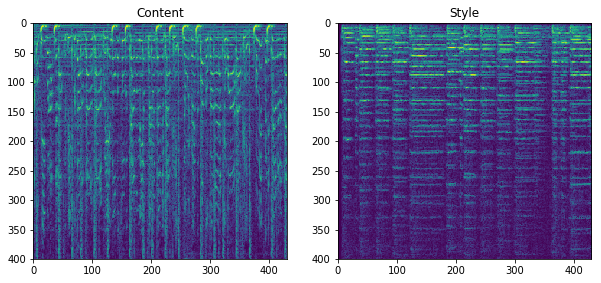

In [5]:
plt.figure(figsize=(10, 5))

# plot for actual content
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content[:400,:])

# plot for transfer
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style[:400,:])

plt.show()

### Compute content and style feats

Filter shape is: filter_height, filter_width, in_channels, out_channels <br>
<br>
Data shape is: batch, in_height, in_width, in_channels

In [6]:
content_ = np.ascontiguousarray(content.T[None,None,:,:])
style_ = np.ascontiguousarray(style.T[None,None,:,:])

std = np.sqrt(2) * np.sqrt(2.0 / ((num_channels + 4096) * 11))
kernel = np.random.randn(1, 11, num_channels, 4096)*std
    
g = tf.Graph()
with g.as_default(), tf.Session() as sess:
    x = tf.placeholder('float32', [1, 1, num_samples, num_channels], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(x, kernel_tf, strides=[1, 1, 1, 1], padding="VALID", name="conv")
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: content_})
    style_features = net.eval(feed_dict={x: style_})
    
    features = np.reshape(style_features, (-1, 4096))
    style_gram = np.matmul(features.T, features) / num_samples

### Optimize

Build graph with variable input

In [7]:
from sys import stderr
iterations = 100

result = None
with tf.Graph().as_default():
    
    x = tf.Variable(np.random.randn(1, 1, num_samples, num_channels).astype(np.float32)*1e-3, name="x")

    # building the Convolutional Neural Network
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(x, kernel_tf, strides=[1, 1, 1, 1], padding="VALID", name="conv")
    net = tf.nn.relu(conv)

    content_loss = 1e-2*2*tf.nn.l2_loss(net-content_features)
    
    style_loss = 0
    
    _, height, width, number = map(lambda i: i.value, net.get_shape())
    
    size = height * width * number
    
    feats = tf.reshape(net, (-1, number))
    
    gram = tf.matmul(tf.transpose(feats), feats)  / num_samples
    
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

    # Overall loss
    loss = content_loss + style_loss
    
    opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': 500})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
       
        print('Optimization Step.....')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

Optimization Step.....
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4288.359375
  Number of iterations: 501
  Number of functions evaluations: 515
Final loss: 4288.3594


### Invert spectrogram and save the result

In [8]:
a = np.zeros_like(content)
a[:num_channels,:] = np.exp(result[0,0].T) - 1

The following block of code performs the 'Phase Reconstruction'

In [9]:
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, 2048))

output_ = 'outputs/out_eminem_usa.wav'
librosa.output.write_wav(output_, x, fs)

In [10]:
print(output_)
display(Audio(output_))

outputs/out_eminem_usa.wav


### Spectrogram after Style Transfer

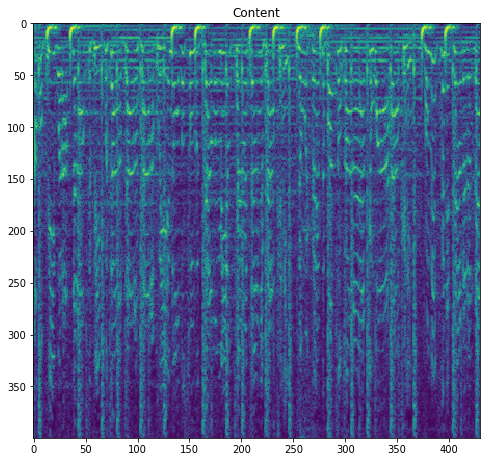

In [11]:
plt.figure(figsize=(8, 8))
plt.title('Content')
plt.imshow(content[:400,:])
plt.show()

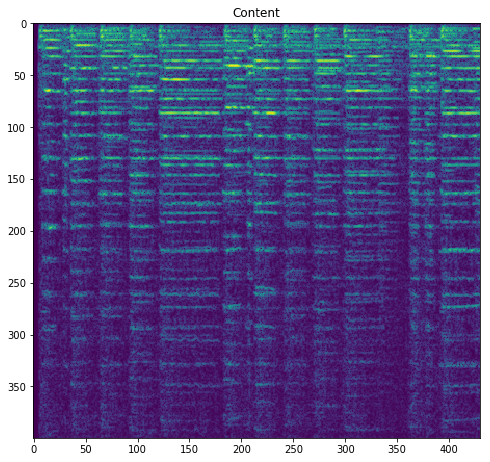

In [12]:
plt.figure(figsize=(8, 8))
plt.title('Content')
plt.imshow(style[:400,:])
plt.show()

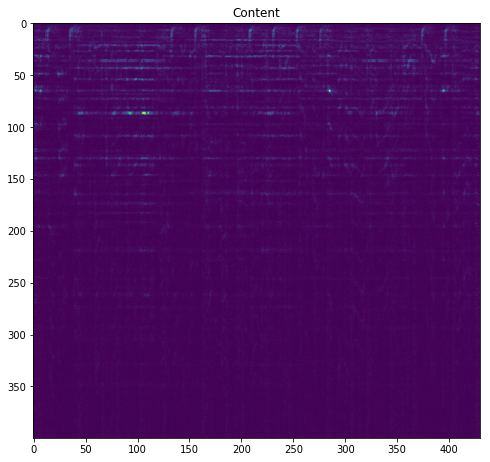

In [13]:
plt.figure(figsize=(8, 8))
plt.title('Content')
plt.imshow(a[:400,:])
plt.show()